In [1]:
# This notebook illustrates handling the September 2024 Demo of the 18-month epi evaluation scenario 2 question 6b

# Import funman related code
import os
from funman.api.run import Runner
from funman import MODE_ODEINT, MODE_SMT
from funman import FunmanWorkRequest, EncodingSchedule 
import json
from funman.representation.constraint import LinearConstraint, ParameterConstraint, StateVariableConstraint
from funman.representation import Interval
import pandas as pd
import logging
import matplotlib.pyplot as plt



RESOURCES = "../../resources"
SAVED_RESULTS_DIR = "./out"

EXAMPLE_DIR = os.path.join(RESOURCES, "amr", "petrinet","monthly-demo", "2024-09")
REQUEST_PATH = os.path.join(
    EXAMPLE_DIR, "eval_scenario_base_request.json")

models = {
    "sidarthe_observables":  os.path.join(
    EXAMPLE_DIR, "SIDARTHE.model.with.observables.json"),
    "sirhd": os.path.join(
    EXAMPLE_DIR, "sirhd.json"),
    "sirhd-vac": os.path.join(
    EXAMPLE_DIR, "sirhd-vac.json"),
}

states = {
    "sidarthe_observables": ['Susceptible', 'Diagnosed', 'Infected', 'Ailing', 'Recognized', 'Healed', 'Threatened', 'Extinct'],
    "sirhd": ["S", "I", "R", "H", "D"],
    "sirhd-vac": ["S_v", "I_v", "R_v", "H_v", "S_u", "I_u", "R_u", "H_u", "D"],
#     "original_stratified":  ["S_compliant", "S_noncompliant", "I_compliant", "I_noncompliant", "E_compliant", "E_noncompliant","R", "H", "D"],
#     "destratified_SEI": ["S_lb", "S_ub", "I_lb", "I_ub", "E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
#     "destratified_SE": ["S_lb", "S_ub", "I_compliant_lb", "I_compliant_ub", "I_noncompliant_lb", "I_noncompliant_ub","E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
#      "destratified_EI": ["I_lb", "I_ub", "S_compliant_lb", "S_compliant_ub", "S_noncompliant_lb", "S_noncompliant_ub","E_lb", "E_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"],
#     "destratified_S": ["S_lb", "S_ub", "I_compliant_lb", "I_compliant_ub", "I_noncompliant_lb", "I_noncompliant_ub","E_compliant_lb", "E_compliant_ub","E_noncompliant_lb", "E_noncompliant_ub","R_lb", "R_ub","H_lb", "H_ub", "D_lb","D_ub"]
}

# basevar_map = [
#     ['S_compliant','S_noncompliant', 'S_lb', 'S_ub','S_compliant_lb', 'S_noncompliant_ub', 'S_compliant_ub', 'S_noncompliant_lb'], 
#     ['I_compliant','I_noncompliant','I_lb','I_ub','I_compliant_lb', 'I_noncompliant_ub', 'I_compliant_ub', 'I_noncompliant_lb'],
#     ['E_compliant','E_noncompliant','E_lb',   'E_ub', 'E_compliant_lb','E_noncompliant_lb', 'E_compliant_ub','E_noncompliant_ub',],
#     ['R','R_lb', 'R_ub'],
#     ['H','H_lb', 'H_ub'],
#     ['D','D_lb', 'D_ub']
#     ]

# hatches= {
#     "original_stratified": '/', 
#     "destratified_SEI": '\\', 
#     "destratified_SE" : '|', 
#     "destratified_S" : '-'
#     #, '+', 'x', 'o', 'O', '.', '*'
# }

request_params = {}
request_results = {}

# Cycle styles for lines
# plt.rcParams['axes.prop_cycle'] = ("cycler('color', 'rgb') +"
                                #    "cycler('lw', [1, 2, 3])")

# %load_ext autoreload
# %autoreload 2

In [2]:
# Constants for the scenario

MAX_TIME=200
STEP_SIZE=1
timepoints = list(range(0, MAX_TIME+STEP_SIZE, STEP_SIZE))
model_str = "sidarthe_observables"
# model_str = "sirhd-vac"

In [3]:
# Helper functions to setup FUNMAN for different steps of the scenario


from funman.server.query import FunmanWorkRequest


def get_request():
    with open(REQUEST_PATH, "r") as request:
        funman_request = FunmanWorkRequest.model_validate(json.load(request))
        return funman_request

def get_model(model):
    return Runner().get_model(model) if isinstance(model, dict) else Runner().get_model(models[model])

def set_timepoints(funman_request, timepoints):
    funman_request.structure_parameters[0].schedules = [EncodingSchedule(timepoints=timepoints)]

def unset_all_labels(funman_request):
    for p in funman_request.parameters:
        p.label = "any"
    
def set_config_options(funman_request, debug=False, dreal_precision=1e-3, mode=MODE_SMT):
    # Overrides for configuration
    #
    # funman_request.config.substitute_subformulas = True
    # funman_request.config.use_transition_symbols = True
    # funman_request.config.use_compartmental_constraints=False
    if debug:
        funman_request.config.save_smtlib="./out"
    funman_request.config.tolerance = 0.01
    funman_request.config.dreal_precision = dreal_precision
    funman_request.config.verbosity = logging.ERROR
    funman_request.config.mode = mode
    # funman_request.config.dreal_log_level = "debug"
    # funman_request.config.dreal_prefer_parameters = ["beta","NPI_mult","r_Sv","r_EI","r_IH_u","r_IH_v","r_HR","r_HD","r_IR_u","r_IR_v"]

def get_synthesized_vars(funman_request):
    return [p.name for p in funman_request.parameters if p.label == "all"]

def run(funman_request, plot=False, model=models['sidarthe_observables']):
    to_synthesize = get_synthesized_vars(funman_request)
    results =  Runner().run(
        model,
        funman_request,
        description="SIERHD Eval 12mo Scenario 1 q1",
        case_out_dir=SAVED_RESULTS_DIR,
        dump_plot=plot,
        print_last_time=True,
        parameters_to_plot=to_synthesize
    )
    return results

def setup_common(funman_request, synthesize=False, debug=False, dreal_precision=1e-1, mode=MODE_SMT):
    set_timepoints(funman_request, timepoints)
    if not synthesize:
        unset_all_labels(funman_request)
    set_config_options(funman_request, debug=debug, dreal_precision=dreal_precision, mode=mode)
    

def set_compartment_bounds(funman_request, model, upper_bound=9830000.0, error=0.01):
    # Add bounds to compartments
    for var in states[model]:
        funman_request.constraints.append(StateVariableConstraint(name=f"{var}_bounds", variable=var, interval=Interval(lb=0, ub=upper_bound, closed_upper_bound=True),soft=False))

    # Add sum of compartments
    funman_request.constraints.append(LinearConstraint(name=f"compartment_bounds", variables=states[model], additive_bounds=Interval(lb=upper_bound-error, ub=upper_bound+error, closed_upper_bound=False), soft=True))

def relax_parameter_bounds(funman_request, factor = 0.1):
    # Relax parameter bounds
    parameters = funman_request.parameters
    for p in parameters:
        interval = p.interval
        width = float(interval.width())
        interval.lb = interval.lb - (factor/2 * width)
        interval.ub = interval.ub + (factor/2 * width)

def plot_last_point(results, states):
    pts = results.parameter_space.points() 
    print(f"{len(pts)} points")

    if len(pts) > 0:
        # Get a plot for last point
        df = results.dataframe(points=pts[-1:])
        # pd.options.plotting.backend = "plotly"
        ax = df[states].plot()
        
    
        fig = plt.figure()
        # fig.set_yscale("log")
        # fig.savefig("save_file_name.pdf")
        plt.close()

def get_last_point_parameters(results):
    pts = results.parameter_space.points()
    if len(pts) > 0:
        pt = pts[-1]
        parameters = results.model._parameter_names()
        param_values = {k:v for k, v in pt.values.items() if k in parameters }
        return param_values

def pretty_print_request_params(params):
    # print(json.dump(params, indent=4))
    if len(params)>0:

        df = pd.DataFrame(params)
        print(df.T)


def report(results, name, states):
    request_results[name] = results
    plot_last_point(results, states)
    param_values = get_last_point_parameters(results)
    # print(f"Point parameters: {param_values}")
    if param_values is not None:
        request_params[name] = param_values
    pretty_print_request_params(request_params)
    

def add_unit_test(funman_request, model="sidarthe_observables"):
    if model == "destratified_SEI":
        mstates = states["destratified_SEI"]
        funman_request.constraints.append(LinearConstraint(name="compartment_lb", soft=False, variables = [s for s in mstates if s.endswith("_lb")],
            additive_bounds= {
                "ub": 19340000.5
            }
        ))
        funman_request.constraints.append(LinearConstraint(name="compartment_ub", soft=False, variables = [s for s in mstates if s.endswith("_ub")],
            additive_bounds= {
                "lb": 0
            }
        ))
        
        


def plot_bounds(point, results, timespan=None, fig=None, axs=None, vars = ["S", "E", "I", "R", "D", "H"], model=None, basevar_map={}, **kwargs):
    
    if point.simulation is not None:
        df = point.simulation.dataframe().T
    else:
        df = results.dataframe([point])
        
    if timespan is not None:
        df = df.loc[timespan[0]:timespan[1]]
        
    # print(df)

    # Drop the ub vars because they are paired with the lb vars 
    no_ub_vars = [v for v in vars if not v.endswith("_ub")]
    no_strat_vars = [v for v in no_ub_vars if not "_noncompliant" in v]

    if fig is None and axs is None:
        fig, axs = plt.subplots(len(basevar_map))
        fig.set_figheight(3*len(basevar_map))
        fig.suptitle('Variable Bounds over time')
        
    for var in no_strat_vars:
        # print(var)
        # Get index of list containing var
        i = next(iter([i for i, bv in enumerate(basevar_map) if var in bv]))
        # print(i)
        if var.endswith("_lb"):
            # var is lower bound
            basevar = var.split("_lb")[0]
            lb = f"{basevar}_lb"
            ub = f"{basevar}_ub"
            labels = [lb, ub]
        elif var.endswith("_ub"):
            # skip, handled as part of lb
            continue
        else:
            # var is not of the form varname_lb
            basevar = var
            labels = basevar
            
            
        if "_compliant" in basevar:
            basevar = basevar.split("_")[0]
            if isinstance(labels, list):
                lb = df[f"{basevar}_compliant_lb"] + df[f"{basevar}_noncompliant_lb"]
                ub = df[f"{basevar}_compliant_ub"] + df[f"{basevar}_noncompliant_ub"]
                labels = [f"{basevar}_lb", f"{basevar}_ub"]
                data = pd.concat([lb, ub],axis=1, keys=labels)
                
            else:
                data = df[f"{basevar}_compliant"] + df[f"{basevar}_noncompliant"]
                labels = f"{basevar}"
        else:
            # print(labels)
            data = df[labels]
            if "_compliant" in basevar:
                basevar = basevar.split("_")[0]
                labels = f"{basevar}"
                
        
        legend_labels = labels
        if model is not None:
            legend_labels = [f"{model}_{k.rsplit('_', 1)[0]}" for k in labels[0:1]][0] if isinstance(labels, list) else f"{model}_{labels}"
        
            
        
        
        # Fill between lb and ub
        if isinstance(labels, list):
            axs[i].fill_between(data.index, data[labels[0]], data[labels[1]], label=legend_labels, **kwargs)
        else:
            if "hatch" in kwargs:
                del kwargs["hatch"]
            if "alpha" in kwargs:
                del kwargs["alpha"]
            axs[i].plot(data, label=legend_labels, **kwargs)
        axs[i].set_title(f"{basevar} Bounds")

        
        # axs[i].set_yscale('logit')
        
        # axs[i].legend(loc="outer")
        axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5),
          ncol=1, fancybox=True, shadow=True, prop={'size': 8}, markerscale=2)
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # fig.tight_layout()
    return fig, axs


1 points
                       alpha     beta    delta  epsilon      eta    gamma  \
sidarthe_observables  0.5643  0.01089  0.01089  0.16929  0.12375  0.45144   

                        kappa   lambda       mu       nu      rho    sigma  \
sidarthe_observables  0.01683  0.03366  0.01683  0.02673  0.03366  0.01683   

                         tau    theta       xi     zeta  
sidarthe_observables  0.0099  0.36729  0.01683  0.12375  


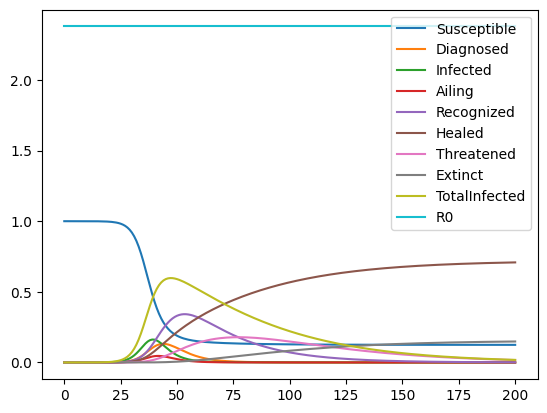

In [4]:
model = get_model(model_str)
to_plot = model[0]._state_var_names() + model[0]._observable_names()

funman_request = get_request()
setup_common(funman_request, debug=False, mode=MODE_ODEINT)
results = run(funman_request, model=models[model_str])
report(results, model_str, to_plot)